Notebook to plot images for figure 2 for MICCAI submission




In [1]:
import numpy as np
import logging
import random
# import logging
# logging.basicConfig(level=logging.DEBUG)

from meld_classifier.meld_cohort import MeldCohort
from meld_graph.dataset import GraphDataset

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


### Plot synthetic

In [3]:
# initialise data_parameters

data_parameters = {
    "augment_data": {
    },
    "combine_hemis": None,
    "dataset": "MELD_dataset_V6.csv",
    "features": [
         '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
         '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh',
         '.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh',
        # '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh',
        ],
    "features_to_exclude": [],
    "features_to_replace_with_0": [],
    "fold_n": 0,
    "group": "control",
    "hdf5_file_root": "{site_code}_{group}_featurematrix_combat_6.hdf5",
    "icosphere_parameters": {"distance_type": "exact"},
    "lesion_bias": 0,
    "lobes": False,
    "number_of_folds": 5,
    "preprocessing_parameters": {
        "scaling": None,
        "zscore": "../data/feature_means.json",
    },
    "scanners": ["15T", "3T"],
    "site_codes": [
         "H4",
    ],
    "smooth_labels": True,
    "subject_features_to_exclude": [],
    "synthetic_data": {
        "bias": 1,
        "jitter_factor": 2,
        "n_subs": 500,
        "n_subtypes": 25,
        "proportion_features_abnormal": 1,
        "proportion_hemispheres_lesional": 0.5,
        "radius": 0.5,
        "run_synthetic": True,
        "smooth_lesion": False,
        "use_controls": True,
    },
}

cohort = MeldCohort(
            hdf5_file_root=data_parameters["hdf5_file_root"], dataset=data_parameters["dataset"]
        )
controls = cohort.get_subject_ids(group='control')
patients = cohort.get_subject_ids(group='patient')

In [5]:
# initialise dictionary to save all results
values={}

In [11]:
#loop over experiments
labels_to_pair=[]
for exp in [
        # 'radius0.5', 'radius2',
         'bias0.1','bias1', 
         'bias2',
        #  'real_patients', 
        #  'real_controls'
         ]:
    if exp=='radius0.5':
        data_parameters['synthetic_data']['run_synthetic'] = True
        data_parameters['synthetic_data']['radius'] = 0.5
        subjects=controls
    elif exp=='radius2':
        data_parameters['synthetic_data']['run_synthetic'] = True
        data_parameters['synthetic_data']['radius'] = 2
        subjects=controls
    elif exp=='bias0.1':
        data_parameters['synthetic_data']['run_synthetic'] = True
        data_parameters['synthetic_data']['radius'] = 2
        data_parameters['synthetic_data']['bias'] = 0.1
        subjects=controls
    elif exp=='bias1':
        data_parameters['synthetic_data']['run_synthetic'] = True
        data_parameters['synthetic_data']['radius'] = 2
        data_parameters['synthetic_data']['bias'] = 1
        subjects=controls
    elif exp=='bias2':
        data_parameters['synthetic_data']['run_synthetic'] = True
        data_parameters['synthetic_data']['radius'] = 2
        data_parameters['synthetic_data']['bias'] = 2
        subjects=controls
    elif exp=='real_patients':
        data_parameters['synthetic_data']['run_synthetic'] = False
        subjects=patients
    elif exp=='real_controls':
        data_parameters['synthetic_data']['run_synthetic'] = False
        subjects=controls
    else:
        print('exp does not exists')


    dataset = GraphDataset(subjects, cohort, data_parameters, mode='test' , distance_maps=True)

    flair_lesion = []
    thick_lesion = []
    wg_lesion = []
    # intrinsic_nonlesion = []
    # thick_nonlesion = []
    # wg_nonlesion = []
    lesion_size = []

    if exp != 'real_controls':
        for i in range(0, len(dataset.data_list)):
            #get lesion size
            labels = dataset.data_list[i]['labels']
            if labels.sum() != 0:
                lesion_size.append(labels.sum())
                if exp== 'real_patients':
                    labels_to_pair.append(labels)

                # get feature values in lesion
                feats_lesion = dataset.data_list[i]['features'][(labels==1)&cohort.cortex_mask,:]
                feats_nolesion = dataset.data_list[i]['features'][(labels!=1)&cohort.cortex_mask,:]
                if feats_nolesion[:,0].any() != 0:
                    flair_lesion.append((abs(feats_lesion[:,0])).mean())
                thick_lesion.append((abs(feats_lesion[:,1])).mean())
                wg_lesion.append((abs(feats_lesion[:,2])).mean())

    else:
        for i,sub in enumerate(range(0, len(dataset.data_list),2)):
            #pair with patients to get mask
            index_pairing = random.randint(0, len(labels_to_pair)-1)
            labels = labels_to_pair[i]
            if labels.sum() != 0:
                # get feature values in lesion
                feats_lesion = dataset.data_list[sub]['features'][(labels==1)&cohort.cortex_mask,:]
                feats_nolesion = dataset.data_list[sub]['features'][(labels!=1)&cohort.cortex_mask,:]
                if feats_nolesion[:,0].any() != 0:
                    flair_lesion.append((abs(feats_lesion[:,0])).mean())
                thick_lesion.append((abs(feats_lesion[:,1])).mean())
                wg_lesion.append((abs(feats_lesion[:,2])).mean())
        
    values[exp]={}
    values[exp]['FLAIR'] = flair_lesion
    values[exp]['thickness'] = thick_lesion
    values[exp]['g-w contrast'] = wg_lesion
    # values[exp]['intrinsic curvature healthy'] = intrinsic_nonlesion
    # values[exp]['thickness healthy'] = thick_nonlesion
    # values[exp]['g-w contrast healthy'] = wg_nonlesion
    values[exp]['lesion size'] = lesion_size



dataset using distance_maps
dataset using distance_maps
dataset using distance_maps


## plot lesion size

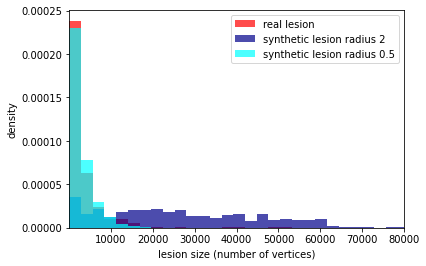

In [7]:
import matplotlib.pyplot as plt
bins=np.histogram(np.hstack((values['real_patients']['lesion size'],
                            values['radius2']['lesion size'],
                            values['radius0.5']['lesion size'])), bins=40)[1]
plt.hist(values['real_patients']['lesion size'], bins=bins, label='real lesion', color='red', alpha=0.7, density=True)
plt.hist(values['radius2']['lesion size'], bins=bins, label='synthetic lesion radius 2', color='darkblue', alpha=0.7, density=True)
plt.hist(values['radius0.5']['lesion size'], bins=bins, label='synthetic lesion radius 0.5', color='cyan', alpha=0.7, density=True)
plt.xlabel("lesion size (number of vertices)")
plt.ylabel("density")
plt.xlim(xmin=1, xmax = 80000)
plt.legend()

## plot features 

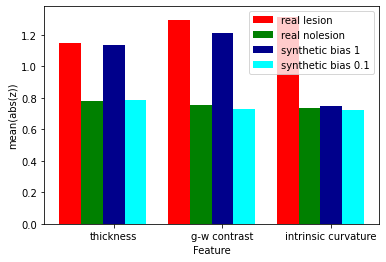

In [16]:
# # plot barplot

# X = ['thickness','g-w contrast', 'intrinsic curvature']
# bias1 = [np.array(values['bias1'][f'{feature} lesion']).mean() for feature in X]
# bias01 = [np.array(values['bias0.1'][f'{feature} lesion']).mean() for feature in X]
# real_les = [np.array(values['real'][f'{feature} lesion']).mean() for feature in X]
# real_noles = [np.array(values['real'][f'{feature} healthy']).mean() for feature in X]

# X_axis = np.arange(len(X))

# plt.bar(X_axis -0.4, real_les, 0.2, label = 'real lesion', color='red')
# plt.bar(X_axis -0.2, real_noles, 0.2, label = 'real nolesion', color='green')
# plt.bar(X_axis + 0, bias1, 0.2, label = 'synthetic bias 1', color='darkblue')
# plt.bar(X_axis + 0.2, bias01, 0.2, label = 'synthetic bias 0.1', color='cyan')

# plt.xticks(X_axis, X)
# plt.xlabel("Feature")
# plt.ylabel("mean(abs(z))")
# plt.legend()
# plt.show()

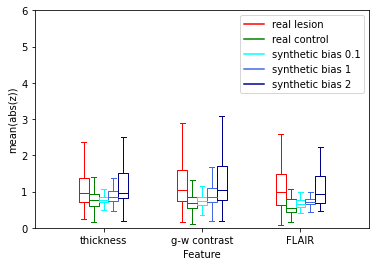

In [12]:
# plot boxplot
X = ['thickness','g-w contrast', 'FLAIR']
bias1 = [np.array(values['bias1'][f'{feature}']) for feature in X]
bias01 = [np.array(values['bias0.1'][f'{feature}']) for feature in X]
bias2 = [np.array(values['bias2'][f'{feature}']) for feature in X]
real_les = [np.array(values['real_patients'][f'{feature}'])for feature in X]
real_noles = [np.array(values['real_controls'][f'{feature}']) for feature in X]

X_axis = np.arange(len(X))

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
bp1=plt.boxplot(real_les, positions=np.array(range(len(real_les)))-0.2, sym='', widths=0.1)
bp2=plt.boxplot(real_noles, positions= np.array(range(len(real_noles)))-0.1, sym='', widths=0.1, )
bp3=plt.boxplot(bias01, positions =  np.array(range(len(bias01))),sym='', widths=0.1)
bp4=plt.boxplot(bias1, positions=  np.array(range(len(bias1))) +0.1 ,sym='', widths=0.1,)
bp5=plt.boxplot(bias2, positions=  np.array(range(len(bias2))) +0.2 ,sym='', widths=0.1,)


set_box_color(bp1, 'red') 
set_box_color(bp2, 'green')
set_box_color(bp3, 'cyan')
set_box_color(bp4, 'royalblue') 
set_box_color(bp5, 'darkblue') 


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='red', label='real lesion')
plt.plot([], c='green', label='real control')
plt.plot([], c='cyan', label='synthetic bias 0.1')
plt.plot([], c='royalblue', label='synthetic bias 1')
plt.plot([], c='darkblue', label='synthetic bias 2')
plt.legend()
plt.xticks(X_axis, X)
plt.ylim(ymin=0, ymax = 6)
plt.xlabel("Feature")
plt.ylabel("mean(abs(z))")
plt.show()

In [74]:
values['bias2']['thickness']

[0.7262743,
 2.1985471,
 3.2422411,
 0.8093941,
 1.7089326,
 2.5687068,
 1.1122878,
 1.2597517,
 1.4818616,
 3.485998,
 5.4383416,
 2.458227,
 0.61150366,
 2.630335,
 0.9378763,
 2.1830819,
 3.5127213,
 4.9968605,
 1.7599149,
 1.2473372,
 2.2497563,
 2.065086,
 1.4747792,
 5.6808877,
 1.5622951,
 0.97984105,
 1.9204972,
 2.4520483,
 1.4451455,
 1.0775465,
 1.0844115,
 0.74200195,
 0.49519292,
 0.92750657,
 1.584726,
 2.62751,
 2.3079705,
 0.60516846,
 2.0977204,
 1.4412124,
 0.8148257,
 1.4734743,
 0.5663975,
 1.3706716,
 2.704705,
 1.1036094,
 2.2761066,
 2.2314467,
 3.542686,
 2.235468,
 1.305146,
 0.8238214,
 1.4686913,
 0.6262437,
 1.2994053,
 1.2024244,
 0.79999006,
 1.0511793,
 1.5392812,
 0.93325686,
 1.3363694,
 1.1821898,
 0.76593065,
 2.7038653,
 1.456051,
 1.0075176,
 1.3192878,
 1.2249455,
 6.1456404,
 1.2240206,
 2.43178,
 2.0485158,
 2.3343115,
 1.9812454,
 4.2531404,
 0.87991095,
 3.6104963,
 1.5964648,
 0.9233591,
 3.0118322,
 1.0690958,
 0.7068666,
 0.7782017,
 1.83638

In [42]:
values['bias2']['FLAIR']

[0.7898661,
 0.6083854,
 0.68575424,
 0.82538605,
 0.77059126,
 0.5917239,
 0.6778888,
 0.64121896,
 0.9781355,
 0.7889937,
 0.99439394,
 0.7537411,
 0.6967389,
 0.629676,
 0.62637854,
 0.8371905,
 0.71856886,
 0.8999446,
 0.8045213,
 0.6336797,
 0.79842484,
 0.69179916,
 0.6958145,
 0.6153044,
 0.5762828,
 0.8593732,
 0.85215265,
 0.8660276,
 0.67646426,
 0.6335632,
 0.5329303,
 0.72396725,
 0.8648985,
 0.69870913,
 0.6403535,
 0.67296875,
 0.65981895,
 0.49714008,
 0.5923885,
 0.6576496,
 0.5717287,
 0.48634002,
 0.809482,
 0.56753623,
 0.69921094,
 0.7439072,
 0.98822457,
 0.91397315,
 0.83007926,
 0.76114607,
 0.599815,
 0.5343241,
 0.6443854,
 0.55167276,
 0.647598,
 0.79765207,
 0.61919016,
 0.5866262,
 0.75031674,
 0.7118808,
 0.6083851,
 0.73263866,
 0.5701789,
 0.6040997,
 0.5370195,
 0.55430824,
 0.5684293,
 0.6420237,
 0.6901379,
 0.55805874,
 0.55501395,
 0.6196254,
 0.79726887,
 0.812101,
 0.2766985,
 0.46276164,
 0.48123223,
 0.4380946,
 0.38318813,
 0.4646311,
 0.4609823

In [28]:
np.array(values['bias1']['thickness']).mean()

nan